# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-win30'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 30

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18845, 18239)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([30, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([30, 6])

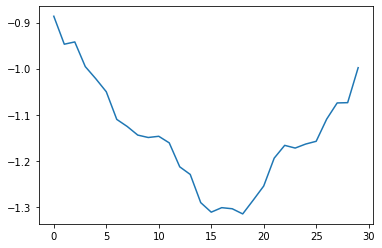

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  19.102291
 - Pitch        :   9.880894
 - Roll         :   2.577696
 - RMS          :  12.505653
 - 99% Tile     :  43.791102
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  15.734408
 - Pitch        :   8.849642
 - Roll         :   2.508293
 - RMS          :  10.522663
 - 99% Tile     :  40.105323
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  12.203824
 - Pitch        :   8.192827
 - Roll         :   2.366776
 - RMS          :   8.595684
 - 99% Tile     :  34.428323
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :  10.046184
 - Pitch        :   7.710406
 - Roll         :   2.396411
 - RMS          :   7.441302
 - 99% Tile     :  30.729634
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.621619
 - Pitch        :   7.213880
 - Roll         :   2.389162
 - RMS          :   6.635271
 - 99% Tile     :  27.541412
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.371032
 - Pitch        :   7.104724
 - Roll         :   2.365617
 - RMS          :   6.066448
 - 99% Tile     :  25.507015
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.159065
 - Pitch        :   7.325993
 - Roll         :   2.390533
 - RMS          :   5.695580
 - 99% Tile     :  24.068863
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.294531
 - Pitch        :   7.118934
 - Roll         :   2.348203
 - RMS          :   5.298595
 - 99% Tile     :  22.125309
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.223691
 - Pitch        :   5.707654
 - Roll         :   2.339630
 - RMS          :   4.316278
 - 99% Tile     :  18.875816
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.452793
 - Pitch        :   4.118469
 - Roll         :   2.351163
 - RMS          :   3.386814
 - 99% Tile     :  16.400386
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.488763
 - Pitch        :   3.254467
 - Roll         :   2.335795
 - RMS          :   3.066973
 - 99% Tile     :  14.788170
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.093204
 - Pitch        :   2.674342
 - Roll         :   2.322340
 - RMS          :   2.714976
 - 99% Tile     :  13.482980
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.408022
 - Pitch        :   2.209387
 - Roll         :   2.299326
 - RMS          :   2.694618
 - 99% Tile     :  12.675869
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.044008
 - Pitch        :   2.140505
 - Roll         :   2.294370
 - RMS          :   2.162087
 - 99% Tile     :  11.805848
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.088913
 - Pitch        :   2.352417
 - Roll         :   2.305031
 - RMS          :   2.251709
 - 99% Tile     :  11.317118
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.851948
 - Pitch        :   1.796490
 - Roll         :   2.280456
 - RMS          :   1.988095
 - 99% Tile     :  10.497308
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.612777
 - Pitch        :   1.727431
 - Roll         :   2.255396
 - RMS          :   2.228410
 - 99% Tile     :  10.665997
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.727634
 - Pitch        :   1.486470
 - Roll         :   2.280143
 - RMS          :   1.861305
 - 99% Tile     :   9.694235
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.441291
 - Pitch        :   2.097154
 - Roll         :   2.249479
 - RMS          :   1.960912
 - 99% Tile     :   9.274280
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.368778
 - Pitch        :   1.580754
 - Roll         :   2.232541
 - RMS          :   1.766029
 - 99% Tile     :   8.953065
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.793313
 - Pitch        :   1.484460
 - Roll         :   2.272628
 - RMS          :   1.878335
 - 99% Tile     :   9.121587
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.642959
 - Pitch        :   1.470767
 - Roll         :   2.242819
 - RMS          :   1.815921
 - 99% Tile     :   8.514561
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.188113
 - Pitch        :   1.345287
 - Roll         :   2.258309
 - RMS          :   1.665470
 - 99% Tile     :   8.394373
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.118498
 - Pitch        :   1.787778
 - Roll         :   2.308187
 - RMS          :   2.082619
 - 99% Tile     :   8.512971
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.652065
 - Pitch        :   1.406128
 - Roll         :   2.359884
 - RMS          :   1.850727
 - 99% Tile     :   8.326557
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.577224
 - Pitch        :   1.522689
 - Roll         :   2.318032
 - RMS          :   1.842054
 - 99% Tile     :   8.124360
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.343380
 - Pitch        :   1.229263
 - Roll         :   2.262954
 - RMS          :   1.676973
 - 99% Tile     :   8.030156
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.451421
 - Pitch        :   1.390250
 - Roll         :   2.220045
 - RMS          :   2.071301
 - 99% Tile     :   8.254968
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.194831
 - Pitch        :   1.317373
 - Roll         :   2.281964
 - RMS          :   1.670374
 - 99% Tile     :   8.180009
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.204546
 - Pitch        :   1.152663
 - Roll         :   2.250342
 - RMS          :   1.616952
 - 99% Tile     :   8.120817
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.473779
 - Pitch        :   1.216992
 - Roll         :   2.270681
 - RMS          :   1.713582
 - 99% Tile     :   7.795424
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.269435
 - Pitch        :   1.181292
 - Roll         :   2.291973
 - RMS          :   1.659323
 - 99% Tile     :   7.794506
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.141604
 - Pitch        :   1.582011
 - Roll         :   2.287189
 - RMS          :   1.735632
 - 99% Tile     :   7.868273
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.296868
 - Pitch        :   1.173973
 - Roll         :   2.327145
 - RMS          :   1.680841
 - 99% Tile     :   7.988468
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.626773
 - Pitch        :   1.365309
 - Roll         :   2.272304
 - RMS          :   1.795720
 - 99% Tile     :   8.033576
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.325628
 - Pitch        :   1.125852
 - Roll         :   2.310477
 - RMS          :   1.669644
 - 99% Tile     :   7.717275
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.400075
 - Pitch        :   1.221933
 - Roll         :   2.245631
 - RMS          :   1.682874
 - 99% Tile     :   7.669496
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.250955
 - Pitch        :   1.089287
 - Roll         :   2.292964
 - RMS          :   1.633923
 - 99% Tile     :   7.861794
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.110240
 - Pitch        :   1.371193
 - Roll         :   2.317888
 - RMS          :   1.681805
 - 99% Tile     :   7.787619
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.546804
 - Pitch        :   1.159156
 - Roll         :   2.332936
 - RMS          :   1.749175
 - 99% Tile     :   7.960135
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.143679
 - Pitch        :   1.111852
 - Roll         :   2.286046
 - RMS          :   1.609371
 - 99% Tile     :   7.842060
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.622552
 - Pitch        :   1.354044
 - Roll         :   2.222276
 - RMS          :   1.770557
 - 99% Tile     :   7.933232
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.274698
 - Pitch        :   1.025255
 - Roll         :   2.232729
 - RMS          :   1.598028
 - 99% Tile     :   7.848507
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.335234
 - Pitch        :   1.096092
 - Roll         :   2.268693
 - RMS          :   1.646333
 - 99% Tile     :   7.923812
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.221880
 - Pitch        :   1.027549
 - Roll         :   2.235799
 - RMS          :   1.586153
 - 99% Tile     :   7.858769
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.067967
 - Pitch        :   1.153051
 - Roll         :   2.253890
 - RMS          :   1.586411
 - 99% Tile     :   7.363181
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.072614
 - Pitch        :   1.020677
 - Roll         :   2.212840
 - RMS          :   1.537199
 - 99% Tile     :   7.421308
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.094714
 - Pitch        :   1.136496
 - Roll         :   2.208129
 - RMS          :   1.566935
 - 99% Tile     :   7.399449
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.264799
 - Pitch        :   1.101844
 - Roll         :   2.183625
 - RMS          :   1.589758
 - 99% Tile     :   7.216390
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.263688
 - Pitch        :   1.261079
 - Roll         :   1.861972
 - RMS          :   1.489313
 - 99% Tile     :   7.391910
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.811517
 - Pitch        :   1.003823
 - Roll         :   1.378192
 - RMS          :   1.436276
 - 99% Tile     :   6.862754
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.337151
 - Pitch        :   1.024556
 - Roll         :   1.277341
 - RMS          :   1.220558
 - 99% Tile     :   6.353906
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.614606
 - Pitch        :   1.069259
 - Roll         :   1.078778
 - RMS          :   1.279848
 - 99% Tile     :   6.529316
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.082631
 - Pitch        :   0.911619
 - Roll         :   0.949020
 - RMS          :   0.983832
 - 99% Tile     :   5.959009
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.286817
 - Pitch        :   0.973731
 - Roll         :   1.004639
 - RMS          :   1.097474
 - 99% Tile     :   6.336371
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.164100
 - Pitch        :   0.871861
 - Roll         :   0.904431
 - RMS          :   0.988815
 - 99% Tile     :   5.933110
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.296455
 - Pitch        :   1.023407
 - Roll         :   0.784709
 - RMS          :   1.055766
 - 99% Tile     :   6.265143
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.329468
 - Pitch        :   1.043300
 - Roll         :   0.778232
 - RMS          :   1.074183
 - 99% Tile     :   5.839473
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.069705
 - Pitch        :   0.833408
 - Roll         :   0.810150
 - RMS          :   0.911991
 - 99% Tile     :   5.776176
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.148988
 - Pitch        :   0.941561
 - Roll         :   0.920714
 - RMS          :   1.009030
 - 99% Tile     :   6.129130
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.990429
 - Pitch        :   1.168381
 - Roll         :   0.793534
 - RMS          :   1.409092
 - 99% Tile     :   6.652991
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.496454
 - Pitch        :   0.870933
 - Roll         :   0.811945
 - RMS          :   1.104106
 - 99% Tile     :   5.639651
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.072365
 - Pitch        :   0.921993
 - Roll         :   0.778876
 - RMS          :   0.932145
 - 99% Tile     :   5.404570
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.165372
 - Pitch        :   1.107600
 - Roll         :   0.744412
 - RMS          :   1.022907
 - 99% Tile     :   5.648009
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.142371
 - Pitch        :   0.784718
 - Roll         :   0.665938
 - RMS          :   0.887744
 - 99% Tile     :   5.453196
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.928926
 - Pitch        :   0.851646
 - Roll         :   0.714660
 - RMS          :   0.836450
 - 99% Tile     :   5.245344
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.959460
 - Pitch        :   0.743509
 - Roll         :   0.664806
 - RMS          :   0.799028
 - 99% Tile     :   5.305079
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.228583
 - Pitch        :   0.849175
 - Roll         :   0.732159
 - RMS          :   0.960308
 - 99% Tile     :   5.433509
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.949891
 - Pitch        :   0.793347
 - Roll         :   0.679347
 - RMS          :   0.815109
 - 99% Tile     :   5.194663
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.096056
 - Pitch        :   0.717591
 - Roll         :   0.680885
 - RMS          :   0.852424
 - 99% Tile     :   5.347985
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.987770
 - Pitch        :   0.707119
 - Roll         :   0.653421
 - RMS          :   0.796381
 - 99% Tile     :   5.026559
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.001532
 - Pitch        :   0.733978
 - Roll         :   0.665780
 - RMS          :   0.813440
 - 99% Tile     :   5.415478
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0072.npy


[0074/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.916501
 - Pitch        :   0.869756
 - Roll         :   0.706541
 - RMS          :   0.835793
 - 99% Tile     :   5.133851
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0073.npy


[0075/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.288948
 - Pitch        :   0.796477
 - Roll         :   0.650790
 - RMS          :   0.952066
 - 99% Tile     :   5.183309
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0074.npy


[0076/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.036045
 - Pitch        :   0.758116
 - Roll         :   0.615257
 - RMS          :   0.821923
 - 99% Tile     :   5.399572
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0075.npy


[0077/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.938418
 - Pitch        :   0.765146
 - Roll         :   0.613635
 - RMS          :   0.783714
 - 99% Tile     :   5.181151
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0076.npy


[0078/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.917062
 - Pitch        :   0.706124
 - Roll         :   0.625491
 - RMS          :   0.759573
 - 99% Tile     :   5.122910
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0077.npy


[0079/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.190427
 - Pitch        :   0.712448
 - Roll         :   0.605661
 - RMS          :   0.873980
 - 99% Tile     :   5.044164
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0078.npy


[0080/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   1.043263
 - Pitch        :   0.683484
 - Roll         :   0.602895
 - RMS          :   0.799798
 - 99% Tile     :   5.106524
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0079.npy


[0081/0100] Train:   0%|                                                     | 0/74 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.938051
 - Pitch        :   0.732947
 - Roll         :   0.606357
 - RMS          :   0.771323
 - 99% Tile     :   5.089046
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0080.npy


[0081/0100] Validation: 100%|██████████████████████| 72/72 [00:02<00:00, 34.78it/s, val_loss 2.0860]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.952947
 - Pitch        :   0.710784
 - Roll         :   0.631511
 - RMS          :   0.777202
 - 99% Tile     :   5.072411
Save output signals into checkpoint/1122-Scene3-CLSTM2-win30/sample/0081.npy
